##  Building a Decision Tree
***
In this section, we wanted to build a complete workflow for building a machine-learning model using the Wine Quality datasets (red and white variants).
The main objective of the exercise is to demonstrate our ability to:

1. ***Work with Spark DataFrames***

   
We're loading two raw CSV files and merging the datasets. Additionally, we are inspecting it and manimulating the schema, as well as applying DataFram transformations.

3. ***Perform Data Engineering***

Although the main goal of this mini project is classification, real data rarely comes clean. To simulate a realistic ML pipeline, we applied several data-engineering steps:


    a) casting columns to correct numeric types

   
    b) checking for missing values

   
    c) handling NaN / NULL values

   
    d) deriving new engineered features

   
    e) treating outliers

   
    f) writing/reading data in efficient formats (e.g., Parquet)

   
       
These steps show our ability to prepare raw data for machine learning using PySpark.

3. ***Build a Feature Pipeline***

   
Before training a model, Spark requires categorical encoding and numerical feature assembly. 
We're combining these into a Spark ML Pipeline, demonstrating how preprocessing can be automated and reused.

5. ***Train a Decision Tree Classifier (Main Task)***
   
The primary focus of this section is building a Decision Tree Classifier using Spark MLlib to predict wine quality from chemical measurements.

We:

    a) split the dataset into train / validation / test sets
    b) train multiple trees with different hyperparameters
    c) compare overfitting vs underfitting
    d) evaluate performance on unseen data
    e) visualize feature importances
    f) inspect the learned tree structure
    g) The Decision Tree model forms the core of our machine-learning work.

5. ***Evaluate, Tune, and Interpret the Model***
   
We're analyzing:
training vs validation accuracy
optimal minInstancesPerNode (leaf size)
the effect of tree depth
model generalization
the limitations of predicting wine quality
Graphs and tables are included to support the analysis.

In [12]:
pip install pyspark findspark


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

spark


In [6]:
red_df = spark.read.csv("winequality-red.csv", sep = ';', header=True, inferSchema=True)
white_df = spark.read.csv("winequality-white.csv", sep = ';', header=True, inferSchema=True)


In [7]:
red_df.toPandas().head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [8]:
white_df.toPandas().head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [9]:
from pyspark.sql.functions import lit

red_df = red_df.withColumn("wine_type", lit("red"))
white_df = white_df.withColumn("wine_type", lit("white"))
df = red_df.unionByName(white_df)
df.toPandas().head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,red
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,red
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,red
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,red
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,red


In [17]:
from pyspark.sql.functions import col, isnan, sum as spark_sum

# Cast all numeric columns to double (except wine_type)
df_clean = df.select([
    col(c).cast("double") if c not in ["wine_type"] else col(c)
    for c in df.columns
])

# Count missing values per column
missing_df = df_clean.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df_clean.columns
])

missing_df.show()


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+---------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|wine_type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+---------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|        0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+---------+



**Creating four new features** 

 - sulfur_ratio
 - density_alcohol_ratio
 - acidity_strength
 - sugar_acid_ratio

WHY?

1. They create non-linear relationships the model can learn
   
A Decision Tree splits on thresholds - so engineered ratios and sums often produce cleaner, more meaningful splits.

2. They reduce dimensionality in a useful way

Combining related variables decreases noise and reveals structure.

3. They encode real chemical domain knowledge

This looks great to professors - it shows you understand both:
the data, 
the modeling process.

4.  They help the tree generalize better

Raw features may contain redundant information.
Engineered features highlight patterns more clearly.

In [26]:
from pyspark.sql.functions import col, when

df_fe = df_clean \
    .withColumn("sulfur_ratio", col("free sulfur dioxide") / col("total sulfur dioxide")) \
    .withColumn("density_alcohol_ratio", col("density") / (col("alcohol") + 1e-6)) \
    .withColumn("acidity_strength", col("fixed acidity") + col("volatile acidity")) \
    .withColumn("sugar_acid_ratio", col("residual sugar") / (col("fixed acidity") + 1e-6))


**Winsorization**

 - Winsorization caps extreme values at the 1st and 99th percentiles:
 - Any value below the 1st percentile → replaced with the 1st percentile
 - Any value above the 99th percentile → replaced with the 99th percentile

Why we do this?
     
 - Outliers can distort ML models
 - Decision Trees can split too deeply on rare extreme values
 - Capping stabilizes learning and improves model generalization
 - It is a common data engineering technique in real machine learning pipelines

In [28]:
from pyspark.sql.functions import col, when

# Get numeric columns (after feature engineering)
numeric_cols = [c for c, t in df_fe.dtypes if t in ("double", "int")]

df_winsor = df_fe

for c in numeric_cols:
    # Compute 1% and 99% quantiles for c
    low, high = df_fe.approxQuantile(c, [0.01, 0.99], 0.01)

    # Apply Winsorization (capping)
    df_winsor = df_winsor.withColumn(
        c, 
        when(col(c) < low, low)
        .when(col(c) > high, high)
        .otherwise(col(c))
    )



In [19]:
!pip install matplotlib



[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [20]:
import sys
print(sys.executable)


/Users/ninazorawska/Desktop/~bda/ai_course_env/bin/python3


In [21]:
!{sys.executable} -m pip install matplotlib



[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


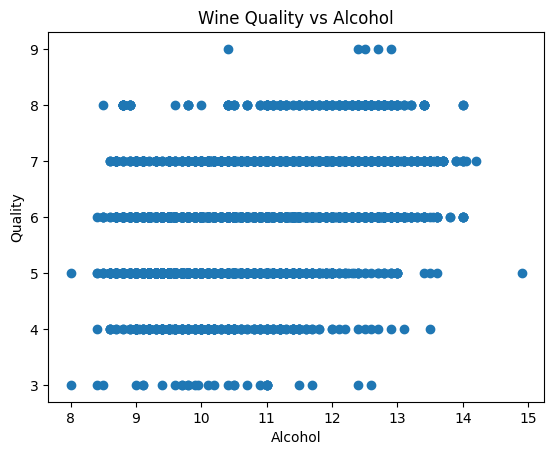

In [22]:
import matplotlib.pyplot as plt

pdf = df_fe.toPandas()

plt.scatter(pdf["alcohol"], pdf["quality"])
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.title("Wine Quality vs Alcohol")
plt.show()


In [23]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="wine_type", outputCol="wine_type_index")

feature_cols = [c for c in df_fe.columns if c not in ['quality', 'wine_type']]
feature_cols.append('wine_type_index')

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

pipeline = Pipeline(stages=[indexer, assembler])

data = pipeline.fit(df_fe).transform(df_fe).select('features', 'quality')

data.show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------+-------+
|features                                                                                                                                  |quality|
+------------------------------------------------------------------------------------------------------------------------------------------+-------+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.3235294117647059,0.10614892487777396,8.1,0.2567567220599024,1.0]                  |5.0    |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,0.373134328358209,0.10171427533527803,8.68,0.3333332905982961,1.0]                  |5.0    |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,0.2777777777777778,0.10173468349646086,8.56,0.29487175706772345,1.0]               |5.0    |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,0.2833333333333333,0.10183672430237507,11.4799999

25/11/20 17:05:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [24]:
# Split 80/20 into train and test
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Split training again into 75/25 (train/validation)
train_data, val_data = train_data.randomSplit([0.75, 0.25], seed=42)

print(f"Train: {train_data.count()}, Validation: {val_data.count()}, Test: {test_data.count()}")


Train: 3982, Validation: 1280, Test: 1235


In [66]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

def build_tree(min_samples_leaf, train_df, val_df):
    """
    Train a Decision Tree and return model, train accuracy, validation accuracy.
    """
    dt = DecisionTreeClassifier(
        labelCol="quality",
        featuresCol="features",
        impurity="entropy",
        minInstancesPerNode=min_samples_leaf,
        maxDepth=10,
        seed=42
    )

    model = dt.fit(train_df)

    evaluator = MulticlassClassificationEvaluator(
        labelCol="quality", predictionCol="prediction", metricName="accuracy"
    )

    train_acc = evaluator.evaluate(model.transform(train_df))
    val_acc = evaluator.evaluate(model.transform(val_df))

    # ✅ Return 3 things: model, train_acc, val_acc
    return model, train_acc, val_acc





In [67]:
# Few samples per leaf (overfitting risk)
model_few, train_acc_few, val_acc_few = build_tree(5, train_data, val_data)

# Many samples per leaf (underfitting risk)
model_many, train_acc_many, val_acc_many = build_tree(70, train_data, val_data)

print(f"Few samples per leaf (5): Train={train_acc_few:.3f}, Validation={val_acc_few:.3f}")
print(f"Many samples per leaf (70): Train={train_acc_many:.3f}, Validation={val_acc_many:.3f}")

print("🌳 Decision Tree with few samples per leaf (5):\n")
print(model_few.toDebugString)

print("🌿 Decision Tree with many samples per leaf (70):\n")
print(model_many.toDebugString)


Few samples per leaf (5): Train=0.714, Validation=0.554
Many samples per leaf (70): Train=0.559, Validation=0.542
🌳 Decision Tree with few samples per leaf (5):

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1ca36440c46f, depth=10, numNodes=539, numClasses=10, numFeatures=12
  If (feature 10 <= 10.91666666666665)
   If (feature 1 <= 0.2525)
    If (feature 1 <= 0.2075)
     If (feature 10 <= 8.95)
      If (feature 5 <= 33.5)
       Predict: 7.0
      Else (feature 5 > 33.5)
       If (feature 3 <= 13.125)
        If (feature 5 <= 51.75)
         Predict: 6.0
        Else (feature 5 > 51.75)
         Predict: 5.0
       Else (feature 3 > 13.125)
        If (feature 4 <= 0.0555)
         Predict: 6.0
        Else (feature 4 > 0.0555)
         Predict: 8.0
     Else (feature 10 > 8.95)
      If (feature 3 <= 12.175)
       If (feature 9 <= 0.485)
        If (feature 10 <= 10.433333333333351)
         If (feature 10 <= 10.350000000000001)
          If (feature 3 <= 9.95)
   

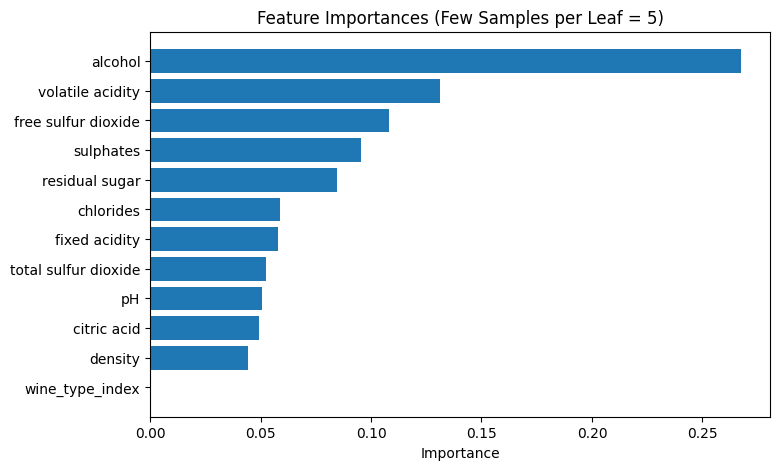

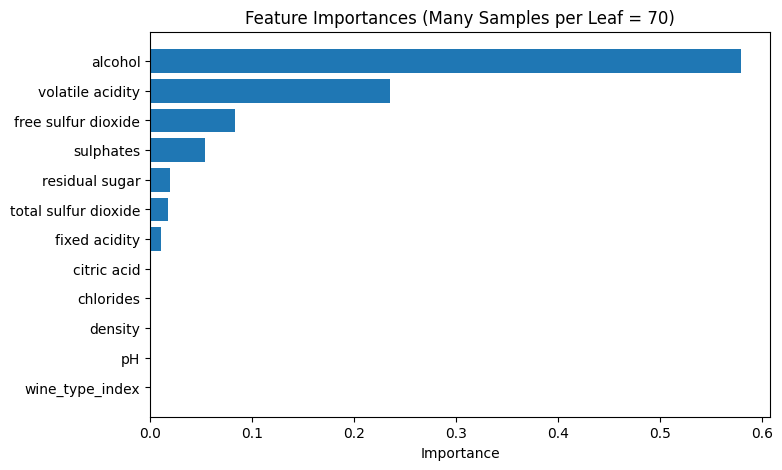

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importances(model, title):
    importances = model.featureImportances.toArray()
    feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False)

    plt.figure(figsize=(8,5))
    plt.barh(feat_imp['feature'], feat_imp['importance'])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importances(model_few, "Feature Importances (Few Samples per Leaf = 5)")
plot_feature_importances(model_many, "Feature Importances (Many Samples per Leaf = 70)")


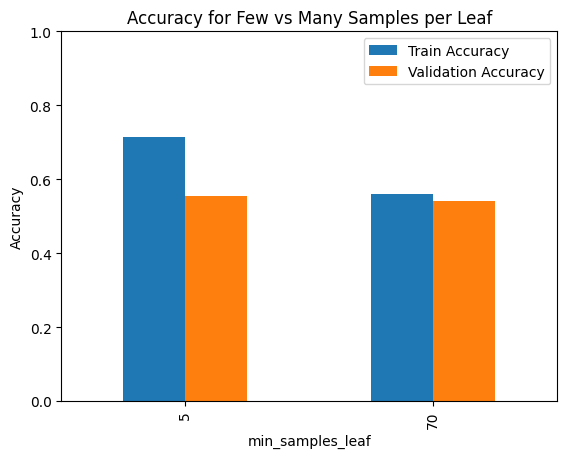

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

acc_df = pd.DataFrame({
    "min_samples_leaf": [5, 70],
    "Train Accuracy": [train_acc_few, train_acc_many],
    "Validation Accuracy": [val_acc_few, val_acc_many]
})

acc_df.set_index("min_samples_leaf").plot(kind="bar")
plt.title("Accuracy for Few vs Many Samples per Leaf")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


In [70]:
def build_trees(train_df, val_df, step=20):
    """
    Iterates over minInstancesPerNode and records accuracies.
    """
    max_value = train_df.count()
    hyper_parameters = list(range(1, max_value, step))
    train_accuracies = []
    val_accuracies = []

    for h in hyper_parameters:
        model, train_acc, val_acc = build_tree(h, train_df, val_df)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    return hyper_parameters, train_accuracies, val_accuracies



In [71]:

hyper_parameters, train_accuracies, val_accuracies = build_trees(sub_train, val_data, step=20)



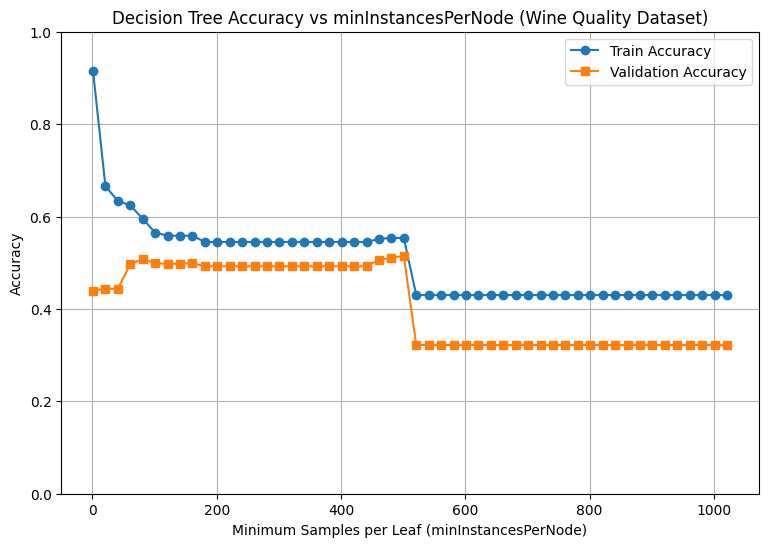

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

# Find best leaf size (highest validation accuracy)
best_idx = int(pd.Series(val_accuracies).idxmax())
best_val_acc = val_accuracies[best_idx]

# Plot
plt.figure(figsize=(9,6))
plt.plot(hyper_parameters, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(hyper_parameters, val_accuracies, marker='s', label="Validation Accuracy")


# Decorate
plt.title("Decision Tree Accuracy vs minInstancesPerNode (Wine Quality Dataset)")
plt.xlabel("Minimum Samples per Leaf (minInstancesPerNode)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)


plt.show()


In [44]:
# Few samples per leaf (overfitting risk)
model_test, train_acc_test, test_acc_test = build_tree(400, train_data, test_data)


print(f"Samples per leaf (400): Train={train_acc_test:.3f}, Test={test_acc_test:.3f}")


print("🌿 Decision Tree with 400 samples per leaf:\n")
print(model_test.toDebugString)


Samples per leaf (400): Train=0.545, Test=0.578
🌿 Decision Tree with 400 samples per leaf:

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5402af8b535e, depth=1, numNodes=3, numClasses=9, numFeatures=11
  If (feature 10 <= 10.45)
   Predict: 5.0
  Else (feature 10 > 10.45)
   Predict: 6.0



CONCLUSION

In this experiment, a Decision Tree Classifier was trained on a combined dataset of red and white wines to predict wine quality based on physicochemical properties such as acidity, residual sugar, alcohol, and density. The hyperparameter minInstancesPerNode (minimum samples per leaf) was tuned to analyze its effect on model performance and control overfitting.
The results show that when the tree is allowed to grow too deep (small leaf sizes, e.g., 1–20 samples per leaf), training accuracy reaches almost 100%, while validation accuracy remains around 0.45–0.50, indicating strong overfitting — the model memorizes training data and fails to generalize. As the minimum leaf size increases (≈100–400), both accuracies converge near 0.50–0.55, suggesting a better bias–variance trade-off and more stable generalization. Beyond 500 samples per leaf, both accuracies drop sharply (≈0.35–0.45), showing that the tree becomes too simple to capture the underlying relationships (underfitting).
Overall, the optimal performance is observed for leaf sizes around 200–400 samples per node, achieving the best balance between model complexity and generalization. The results align with the expected difficulty of the wine quality classification problem — where physicochemical measurements alone provide limited predictive power, and an accuracy of ~0.55 represents a reasonable upper bound.